In [17]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [267]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [268]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.3),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.3),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.3)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [269]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [270]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier[1] = nn.Linear(num_filters, num_classes)

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_feature_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [271]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device, best_accuracy=0.0):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output_loss.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/v2/Basic/SMobileNetV2_rice_pest_classificationV10.pt')

        # scheduler.step(testing_loss)

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_training_result(*results):

    full_train_loss = []
    full_test_loss = []

    for res in results:
        full_train_loss.extend(res.get('train_loss', []))
        full_test_loss.extend(res.get('test_loss', []))

    total_epochs = len(full_train_loss)
    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_train_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for result in results:
        accuracy = result.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)
    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def save_historical_data(*histories, filename='training_results/v2/SMobileNetV2_rice_pest_classificationV10.csv'):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    data_dict = pd.DataFrame({
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")

        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'test_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")


In [18]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
val_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

classes = train_set.classes


Unfreezing the last convolutional block for fine-tuning...

Unfreezing the before last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.17it/s]


Epoch 1/45 | Train Loss: 0.4297 | Test Loss: 0.2834 | Accuracy: 91.89% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 2/45 | Train Loss: 0.4179 | Test Loss: 0.2622 | Accuracy: 92.40% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 3/45 | Train Loss: 0.4102 | Test Loss: 0.2558 | Accuracy: 92.35% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 4/45 | Train Loss: 0.3964 | Test Loss: 0.2442 | Accuracy: 92.59% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 5/45 | Train Loss: 0.3842 | Test Loss: 0.2447 | Accuracy: 92.73% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch 6/45 | Train Loss: 0.3627 | Test Loss: 0.2353 | Accuracy: 92.78% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 7/45 | Train Loss: 0.3681 | Test Loss: 0.2389 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 8/45 | Train Loss: 0.3513 | Test Loss: 0.2304 | Accuracy: 93.15% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 9/45 | Train Loss: 0.3319 | Test Loss: 0.2284 | Accuracy: 92.96% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.43it/s]


Epoch 10/45 | Train Loss: 0.3405 | Test Loss: 0.2280 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 11/45 | Train Loss: 0.3230 | Test Loss: 0.2205 | Accuracy: 93.57% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Epoch 12/45 | Train Loss: 0.3310 | Test Loss: 0.2180 | Accuracy: 93.57% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Epoch 13/45 | Train Loss: 0.3141 | Test Loss: 0.2171 | Accuracy: 93.43% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


Epoch 14/45 | Train Loss: 0.3106 | Test Loss: 0.2185 | Accuracy: 93.29% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


Epoch 15/45 | Train Loss: 0.3135 | Test Loss: 0.2124 | Accuracy: 93.90% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 16/45 | Train Loss: 0.3053 | Test Loss: 0.2056 | Accuracy: 93.90% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 17/45 | Train Loss: 0.3099 | Test Loss: 0.2034 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 18/45 | Train Loss: 0.2901 | Test Loss: 0.2192 | Accuracy: 93.86% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 19/45 | Train Loss: 0.2903 | Test Loss: 0.2091 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 20/45 | Train Loss: 0.2944 | Test Loss: 0.2019 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Epoch 21/45 | Train Loss: 0.2695 | Test Loss: 0.1975 | Accuracy: 94.14% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Epoch 22/45 | Train Loss: 0.2825 | Test Loss: 0.2016 | Accuracy: 94.04% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 23/45 | Train Loss: 0.2834 | Test Loss: 0.2076 | Accuracy: 93.95% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 24: 100%|██████████| 34/34 [00:04<00:00,  7.31it/s]


Epoch 24/45 | Train Loss: 0.2722 | Test Loss: 0.1942 | Accuracy: 94.04% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 25: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Epoch 25/45 | Train Loss: 0.2810 | Test Loss: 0.1942 | Accuracy: 94.28% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 26: 100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Epoch 26/45 | Train Loss: 0.2606 | Test Loss: 0.1956 | Accuracy: 94.00% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 27: 100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Epoch 27/45 | Train Loss: 0.2618 | Test Loss: 0.1958 | Accuracy: 94.09% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 28: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 28/45 | Train Loss: 0.2578 | Test Loss: 0.1989 | Accuracy: 94.14% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 29: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 29/45 | Train Loss: 0.2632 | Test Loss: 0.1989 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 30: 100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


Epoch 30/45 | Train Loss: 0.2639 | Test Loss: 0.1888 | Accuracy: 94.18% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 31: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


Epoch 31/45 | Train Loss: 0.2478 | Test Loss: 0.1909 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 32: 100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 32/45 | Train Loss: 0.2434 | Test Loss: 0.1942 | Accuracy: 94.23% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 33: 100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


Epoch 33/45 | Train Loss: 0.2627 | Test Loss: 0.1942 | Accuracy: 94.28% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 34: 100%|██████████| 34/34 [00:04<00:00,  7.75it/s]


Epoch 34/45 | Train Loss: 0.2420 | Test Loss: 0.1931 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 35: 100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 35/45 | Train Loss: 0.2414 | Test Loss: 0.1914 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 36: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


Epoch 36/45 | Train Loss: 0.2445 | Test Loss: 0.1975 | Accuracy: 94.56% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 37: 100%|██████████| 34/34 [00:04<00:00,  7.59it/s]


Epoch 37/45 | Train Loss: 0.2364 | Test Loss: 0.1911 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 38: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 38/45 | Train Loss: 0.2343 | Test Loss: 0.1892 | Accuracy: 94.37% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 39: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 39/45 | Train Loss: 0.2278 | Test Loss: 0.1925 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


Epoch 40/45 | Train Loss: 0.2294 | Test Loss: 0.1861 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 41: 100%|██████████| 34/34 [00:04<00:00,  7.59it/s]


Epoch 41/45 | Train Loss: 0.2257 | Test Loss: 0.1827 | Accuracy: 94.65% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 42: 100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


Epoch 42/45 | Train Loss: 0.2327 | Test Loss: 0.1883 | Accuracy: 94.61% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 43: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 43/45 | Train Loss: 0.2236 | Test Loss: 0.1943 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 44: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 44/45 | Train Loss: 0.2238 | Test Loss: 0.1898 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB


Test epoch: 45: 100%|██████████| 34/34 [00:04<00:00,  7.69it/s]


Epoch 45/45 | Train Loss: 0.2161 | Test Loss: 0.1880 | Accuracy: 94.42% | GPU Memory (Alloc/Reserved): 0.27/1.842 GB
Phase done!

Unfreezing the third last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


Epoch 1/60 | Train Loss: 0.2221 | Test Loss: 0.1978 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.79it/s]


Epoch 2/60 | Train Loss: 0.2186 | Test Loss: 0.1852 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 3/60 | Train Loss: 0.2237 | Test Loss: 0.1981 | Accuracy: 94.61% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


Epoch 4/60 | Train Loss: 0.1976 | Test Loss: 0.1895 | Accuracy: 94.56% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch 5/60 | Train Loss: 0.2098 | Test Loss: 0.1902 | Accuracy: 94.79% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch 6/60 | Train Loss: 0.2090 | Test Loss: 0.1951 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


Epoch 7/60 | Train Loss: 0.1911 | Test Loss: 0.1850 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.86it/s]


Epoch 8/60 | Train Loss: 0.1961 | Test Loss: 0.1952 | Accuracy: 94.89% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


Epoch 9/60 | Train Loss: 0.2000 | Test Loss: 0.1879 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch 10/60 | Train Loss: 0.1942 | Test Loss: 0.1892 | Accuracy: 94.47% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 11/60 | Train Loss: 0.1962 | Test Loss: 0.1884 | Accuracy: 94.79% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


Epoch 12/60 | Train Loss: 0.1918 | Test Loss: 0.1837 | Accuracy: 94.89% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


Epoch 13/60 | Train Loss: 0.1854 | Test Loss: 0.1857 | Accuracy: 94.98% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 14/60 | Train Loss: 0.1839 | Test Loss: 0.1849 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 15/60 | Train Loss: 0.1746 | Test Loss: 0.1931 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 16/60 | Train Loss: 0.1941 | Test Loss: 0.1854 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.86it/s]


Epoch 17/60 | Train Loss: 0.1819 | Test Loss: 0.1905 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 18/60 | Train Loss: 0.1762 | Test Loss: 0.1821 | Accuracy: 95.12% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.68it/s]


Epoch 19/60 | Train Loss: 0.1721 | Test Loss: 0.1882 | Accuracy: 94.51% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


Epoch 20/60 | Train Loss: 0.1790 | Test Loss: 0.1957 | Accuracy: 94.79% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  7.81it/s]


Epoch 21/60 | Train Loss: 0.1675 | Test Loss: 0.1965 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch 22/60 | Train Loss: 0.1734 | Test Loss: 0.1862 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


Epoch 23/60 | Train Loss: 0.1734 | Test Loss: 0.2129 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 24: 100%|██████████| 34/34 [00:04<00:00,  7.65it/s]


Epoch 24/60 | Train Loss: 0.1651 | Test Loss: 0.1853 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 25: 100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


Epoch 25/60 | Train Loss: 0.1686 | Test Loss: 0.1910 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 26: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 26/60 | Train Loss: 0.1644 | Test Loss: 0.1923 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 27: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 27/60 | Train Loss: 0.1588 | Test Loss: 0.1931 | Accuracy: 94.93% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 28: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Epoch 28/60 | Train Loss: 0.1567 | Test Loss: 0.1886 | Accuracy: 95.08% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 29: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch 29/60 | Train Loss: 0.1645 | Test Loss: 0.1858 | Accuracy: 95.12% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 30: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Epoch 30/60 | Train Loss: 0.1550 | Test Loss: 0.1962 | Accuracy: 94.89% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 31: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 31/60 | Train Loss: 0.1608 | Test Loss: 0.1913 | Accuracy: 94.93% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 32: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 32/60 | Train Loss: 0.1549 | Test Loss: 0.1937 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 33: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 33/60 | Train Loss: 0.1648 | Test Loss: 0.1971 | Accuracy: 94.93% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 34: 100%|██████████| 34/34 [00:04<00:00,  7.68it/s]


Epoch 34/60 | Train Loss: 0.1494 | Test Loss: 0.1981 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 35: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 35/60 | Train Loss: 0.1570 | Test Loss: 0.1915 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 36: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 36/60 | Train Loss: 0.1559 | Test Loss: 0.1972 | Accuracy: 95.08% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 37: 100%|██████████| 34/34 [00:04<00:00,  7.59it/s]


Epoch 37/60 | Train Loss: 0.1342 | Test Loss: 0.1891 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 38: 100%|██████████| 34/34 [00:04<00:00,  7.59it/s]


Epoch 38/60 | Train Loss: 0.1466 | Test Loss: 0.1929 | Accuracy: 94.98% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 39: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 39/60 | Train Loss: 0.1485 | Test Loss: 0.1927 | Accuracy: 95.08% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Epoch 40/60 | Train Loss: 0.1528 | Test Loss: 0.1952 | Accuracy: 94.98% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 41: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 41/60 | Train Loss: 0.1497 | Test Loss: 0.1873 | Accuracy: 94.89% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 42: 100%|██████████| 34/34 [00:04<00:00,  7.63it/s]


Epoch 42/60 | Train Loss: 0.1425 | Test Loss: 0.1982 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 43: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 43/60 | Train Loss: 0.1363 | Test Loss: 0.1826 | Accuracy: 95.26% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 44: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 44/60 | Train Loss: 0.1533 | Test Loss: 0.2032 | Accuracy: 94.89% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 45: 100%|██████████| 34/34 [00:04<00:00,  7.66it/s]


Epoch 45/60 | Train Loss: 0.1327 | Test Loss: 0.1898 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 46: 100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


Epoch 46/60 | Train Loss: 0.1428 | Test Loss: 0.2066 | Accuracy: 95.22% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  7.33it/s]


Epoch 47/60 | Train Loss: 0.1478 | Test Loss: 0.2022 | Accuracy: 95.26% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 48/60 | Train Loss: 0.1390 | Test Loss: 0.1888 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 49: 100%|██████████| 34/34 [00:04<00:00,  7.66it/s]


Epoch 49/60 | Train Loss: 0.1301 | Test Loss: 0.1993 | Accuracy: 95.36% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 50/60 | Train Loss: 0.1331 | Test Loss: 0.2070 | Accuracy: 95.12% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 51/60 | Train Loss: 0.1303 | Test Loss: 0.2261 | Accuracy: 94.98% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 52: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 52/60 | Train Loss: 0.1330 | Test Loss: 0.2031 | Accuracy: 94.84% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Epoch 53/60 | Train Loss: 0.1379 | Test Loss: 0.2153 | Accuracy: 95.17% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch 54/60 | Train Loss: 0.1326 | Test Loss: 0.1981 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 55: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Epoch 55/60 | Train Loss: 0.1343 | Test Loss: 0.2008 | Accuracy: 95.08% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 56: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 56/60 | Train Loss: 0.1363 | Test Loss: 0.1952 | Accuracy: 95.26% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 57: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


Epoch 57/60 | Train Loss: 0.1333 | Test Loss: 0.1940 | Accuracy: 95.26% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 58: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


Epoch 58/60 | Train Loss: 0.1324 | Test Loss: 0.1982 | Accuracy: 95.31% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 59: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 59/60 | Train Loss: 0.1269 | Test Loss: 0.2024 | Accuracy: 95.40% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB


Test epoch: 60: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


Epoch 60/60 | Train Loss: 0.1353 | Test Loss: 0.2058 | Accuracy: 95.03% | GPU Memory (Alloc/Reserved): 0.28/1.844 GB
Phase done!


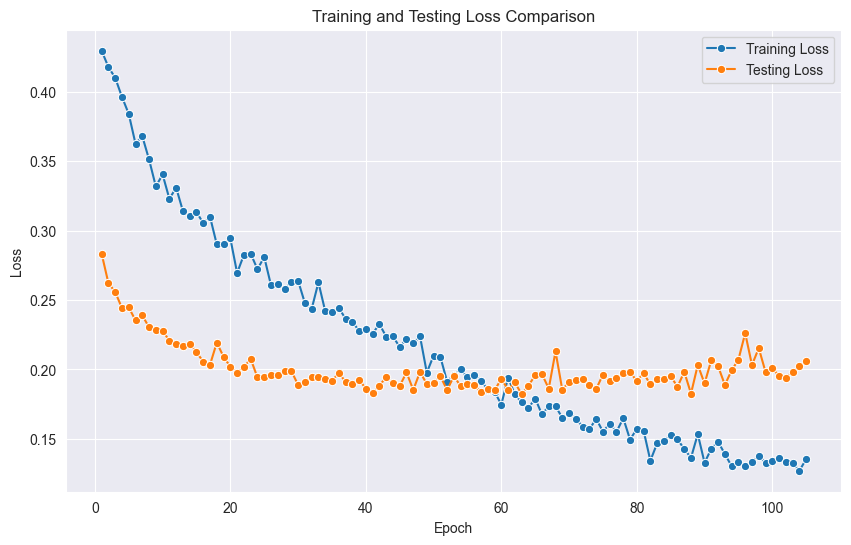

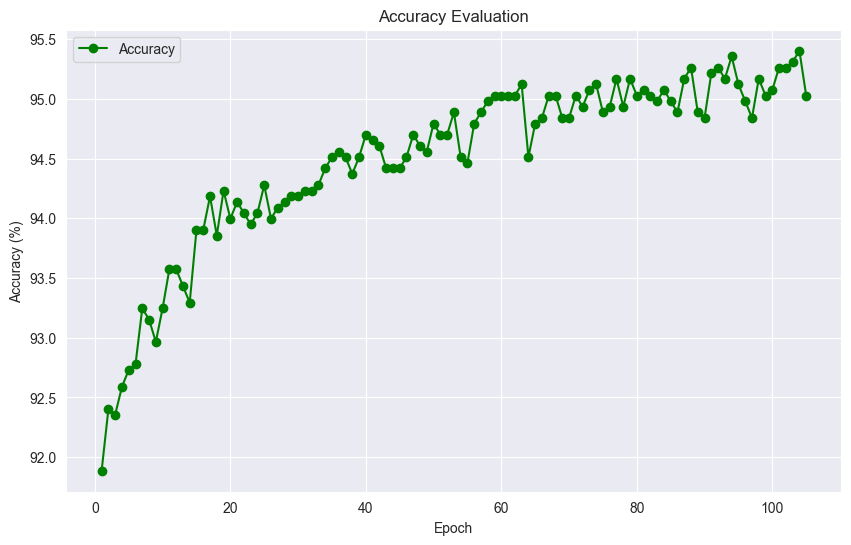

Creating new historical data...
Historical data saved successfully!


In [15]:
import torch.optim as optim

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 64
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
model.load_state_dict(torch.load('models/v2/Basic/SMobileNetV2_rice_pest_classificationV10.pt', map_location=hardware))

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

# result_1, accuracies1 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=15, device=hardware)

optimizer_2 = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=weight_decay)

# result_2, accuracies2 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=30, device=hardware)

model.unfreeze_last_block()
model.unfreeze_before_last_block()

result_3, accuracies3 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=45, device=hardware)

model.unfreeze_third_last_inverse_residual()

result_4, accuracies4 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=60, device=hardware)

plot_training_result(result_3, result_4)
plot_accuracy(result_3, result_4)
save_historical_data(result_3, result_4)

In [273]:
def incremental_training(model, sessions, criterion, train_dataloader, test_dataloader, device):

    full_history = []
    session_best_accuracies = []
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_feature_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)

        session_history, best_overall_accuracy = train_and_test(
            model, optimizer, criterion, train_dataloader, test_dataloader, epochs, device, best_accuracy=best_overall_accuracy
        )

        full_history.append(session_history)

        if session_history['accuracy']:
            best_in_session = max(session_history['accuracy'])
            session_best_accuracies.append(best_in_session)

    return full_history, session_best_accuracies

In [ ]:
import torch.optim as optim

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 32
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
model.load_state_dict(torch.load('models/v2/Basic/SMobileNetV2_rice_pest_classificationV8.pt'))
model.unfreeze_last_block()

training_sessions = [
    {'epochs': 15, 'lr': 1e-3, 'unfreeze_layer': 0},
    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},
    {'epochs': 45, 'lr': 1e-4, 'unfreeze_layer': 2}
]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, device=hardware)

plot_training_result(result)
plot_accuracy(result)
save_historical_data(result)

In [261]:
# mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
#
# for num in range(len(mobilenet_v2.features) - 1, -1, -1):
#     print(num)

my_array = [1, 2, 3, 4, 5]

# print(my_array[-5])

for num in range(1, my_array.__len__() + 1):
    print(num)

1
2
3


In [75]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probability.squeeze().cpu().numpy()


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"\nAccuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [26]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/v2/Basic/SMobileNetV2_rice_pest_classificationV10.pt', map_location=hardware))
image_path = 'unrelated_data/522195740_1082374587297150_2426477586868291111_n.jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

true, pred = eval_metrics(model_inference, val_loader, classes_names, hardware)

ValueError: too many values to unpack (expected 2)